In [1]:
# Intallation packages before use Jupyter

!pip install pandas
!pip install -U scikit-learn
!pip install keras
!pip install matplotlib
!pip install kaleido
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 72.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 693.1 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 47.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 53.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 47.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 69.6 MB/s eta 0:00:0000:0100:01


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
# from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.metrics import Precision, Accuracy
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.optimizers import schedules
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# be able to save images on server
matplotlib.use('Agg')

# Not show warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# !pip install -U kaleido # w Google Colab wymagany Runtime restart po instalacji (Runtime -> Restart Runtime)
import kaleido #required
# kaleido.__version__ #0.2.1

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.16.2
Num GPUs Available:  1


In [3]:
# Zip
# importing the "tarfile" module
import tarfile # type: ignore

# open file
file = tarfile.open('2_150x9.tar.gz')

# extracting a specific file
file.extractall(path='./data/2_150x9/')

file.close()

In [8]:
# Data generator
def data(time, features):
    # Timestep 
    # timestepsPerSample = 20
    timestepsPerSample = time

    # Timesteps in input data
    timestepsPerSampleWholeData = 150

    # Replace 'your_file.csv' with the actual file path
    file_features = './data/2_150x9/2_150x9f.csv'
    file_labels = './data/2_150x9/2_150x9l.csv'

    # Read the .csv file and create an array
    data_strings = np.genfromtxt(file_features, delimiter=';')
    labels_strings = np.genfromtxt(file_labels,delimiter=';')


    # Wycinanie wybranych kolumn
    #  0    1         2             3        4       5        6    7        8
    # RSI, VWAP, HeikenResult, closeHeiken, CMF, Stochastic, OBV, QQE, TrendFilter
    # data_s = data_strings[:,[0,2,3,4,5,6,7,8]]
    if features == 0:
        data_s = data_strings[:,[0,4,5,8]]
    elif features == 1:
        data_s = data_strings[:,[0,1,4,5,6,8]]
    elif features == 2:
        data_s = data_strings[:,:]
        
    num_features = data_s.shape[1]
    # print(data_strings[:3])
    # print(data_s[:3])

    
    # Convert from strings to float and int
    X = data_s.astype(float).reshape((-1,timestepsPerSampleWholeData,num_features))
    Y = labels_strings.astype(float).reshape((-1,6))
    # print(X.shape)
    # print(Y.shape)

    # Modification from imported to new size X[samples,timesteps]
    X_mod = X[1000:11000,timestepsPerSampleWholeData - timestepsPerSample:]
    Y_mod = Y[1000:11000]
    timestepsPerSampleWholeData = X_mod.shape[1]
    # print(X_mod.shape)
    # print(Y_mod.shape)
    # print(X_mod[:1])

    # Splitting
    x_train, x_test, Y_train, Y_test = train_test_split(X_mod,Y_mod, test_size=0.15, shuffle=False)
    y_train = Y_train[:, 0:2]
    y_test = Y_test[:, 0:2]
    # print(y_train[:2])
    # print(y_test[:2])

    # Summarize
    num_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f"Train shape: {x_train.shape}")
    print(f"Timesteps: {timestepsPerSampleWholeData}")
    print(f"Train Samples: {num_samples}")
    print(f"Test Samples: {test_samples}")
    print(f"Num features: {num_features}")
    return x_train, x_test, y_train, y_test, Y_test

In [9]:
# fit lstm model
from tabnanny import verbose

def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)


def fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, nb_epoch, neurons, denseType, dropout, model, learning_rate):
    LstmLayer = LSTM(
    units=neurons,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True, # true if cuDNN
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=dropout, # !important parameter for optimization => 0 if cuDNN
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False, # false if cuDNN
    input_shape=(x_train.shape[1],x_train.shape[2]),
    # input_dim=(x_train.shape[1])
    ) 

    if model == 0:
        model = Sequential() # initializing model
        # input layer and LSTM layer with 50 neurons
        model.add(LstmLayer)
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(20, activation='relu'))
        # outpute layer with sigmoid activation
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
    if model == 1:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=25))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 2:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=150, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=75))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 3:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=300, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=300, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=150))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
    
    # Callback Checkpoint
    checkpoint = ModelCheckpoint(
            filepath='./saved_models/last_saved_model.keras',
            save_best_only=True,
            monitor='val_loss',
            verbose=1
            )

    # Callback EarlyStopping
    earlyStopping = EarlyStopping(monitor='val_loss',
                                             start_from_epoch=190,
                                             restore_best_weights=True,
                                             verbose=0,
                                             patience=3)
    
    #  Callback profit
    profitList = list()
    class MyCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            predict = model.predict(x_test, batch_size=batch_size)
            profit = funcProfit(predict, Y_test)
            profitList.append(profit)
            print(f"Profit: {profit}")


    # Optimizer
    num_samples = x_train.shape[0]
    STEPS_PER_EPOCH = num_samples/batch_size

    lr_schedule = schedules.InverseTimeDecay(
    # lr_schedule = schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=0.9,
    staircase=False)

    def get_optimizer():
         # return tf.keras.optimizers.Adam(learning_rate=0.001)
        # return tf.keras.optimizers.Adam() # type: ignore
        # return tf.keras.optimizers.RMSprop(learning_rate=learning_rate) # type: ignore
        return tf.keras.optimizers.Adam(learning_rate= lr_schedule) # type: ignore

    optimizer = get_optimizer()

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

    # Save initial weights on first compile. In next compile restore initial weights
    if i == 0:
        model.save_weights("./saved_models/initial.weights.h5")
    elif i > 0:
        shuffle_weights(model, weights=None)
        
    model.summary()

    # fit model
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, 
                        shuffle=False, validation_data=(x_test, y_test), callbacks=[checkpoint, earlyStopping, MyCallback()], verbose=2) # type: ignore
    
    # Convert list() to array
    profitArray = np.array(profitList)
    
    return model, history, profitArray

In [15]:
# Profit old
def funcProfitOld(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price', 'Open', 'High', 'Low'])

    # Absolute difference prices
    sum = 0
    for i in range(0, len(df)):
        if (i-1) > 0:
            diff = abs((df.at[i,'Sell'] - df.at[i-1,'Sell']))
            if diff < 0.5:
                if df.at[i,'Sell'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])*(-1)
                elif df.at[i,'Buy'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])
                if df.at[i,'Sell'] != df.at[i-1,'Sell']:
                    sum -= 0.03
    return sum


# Profit
def funcProfit(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])

    # Absolute difference prices
    spread = 0.03
    tp = 1000 # 0.20
    sum = 0
    sell = 0
    buy = 0
    for i in range(0, len(df)):
        if (i-1) >= 0:
            if df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] < 0.2:                  # S 0 1 
                if buy > 0:
                    sell = df.at[i,'Open'] - spread
                    sum += df.at[i,'Open'] - buy
                    buy = 0
                elif sell == 0:
                    sell = df.at[i,'Open'] - spread
            elif df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] > 0.8 and sell > 0:   # S 1 1 sell >0
                if df.at[i-1,'High'] >= (sell + tp):
                    sum -= tp
                    sell = 0
                if df.at[i-1,'Low'] <= (sell - tp):
                    sum += tp
                    sell = 0
# --------------------------------------------------------------------------------------------------------

            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] < 0.2:               # B 0 1 
                if sell > 0:
                    buy = df.at[i,'Open'] + spread
                    sum += sell - df.at[i,'Open']
                    sell = 0
                elif buy == 0:
                    buy = df.at[i,'Open'] + spread
            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] > 0.8 and buy > 0:   # B 1 1 buy >0
                if df.at[i-1,'Low'] <= (buy - tp):
                    sum -= tp
                    buy = 0
                if df.at[i-1,'High'] >= (buy + tp):
                    sum += tp
                    buy = 0

    return round(sum, 2)

In [16]:
# Experiment
def experiment(i, repeats, epochs, neurons, time, denseType, dropout, model, features, learning_rate):
    # # Data gen
    # x_train, x_test, y_train, y_test, Y_test = data(time, features)

    # Evaluate declaration
    accuracy = list()
    profit = list()
    profitOld = list()
    metrics = list()

    # Repeats
    for r in range(repeats):
        print(f"Repeat {r} running...")
        # Batch size
        batch_size = 64
        # model
        model, history, profitArray = fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, epochs, neurons, denseType, dropout, model, learning_rate)
        i += 1
        
        # forecast the entire training dataset to build up state for forecasting
        model = load_model(filepath="./saved_models/last_saved_model.keras")
        predict = model.predict(x_test, batch_size=batch_size)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # type: ignore

        metric = pd.DataFrame(history.history)
        metric['epoch'] = history.epoch
        # Add column Profit with profit result for epoch
        metric = metric.assign(Profit=profitArray)

        metrics.append(metric)
        accuracy.append(test_acc*100)
        profit.append(funcProfit(predict, Y_test))
        profitOld.append(funcProfitOld(predict, Y_test))
    
    return accuracy, profit, profitOld, metrics

In [17]:
# Output
def plotsOut(d, metrics):
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Accuracy', 'Loss', 'Profit'))

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1300
    )

    for idx, m in enumerate(metrics):
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['accuracy'], name=f'accuracy{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['loss'], name=f'loss{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_accuracy'], name=f'val_accuracy{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_loss'], name=f'val_loss{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['Profit'], name=f'profit{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=3)

    fig.update_xaxes(title_text='epochs')
    fig.update_yaxes(title_text='')
    # fig.update_layout(width=1000, title='Accuracy and Loss')
    fig.write_image(file=f"compare_models_{str(d)}.jpg", engine="kaleido")
    fig.show()

Train shape: (8500, 150, 4)
Timesteps: 150
Train Samples: 8500
Test Samples: 1500
Num features: 4
0 Model test start...
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.61508, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Profit: 4.28
133/133 - 5s - 36ms/step - accuracy: 0.6285 - loss: 0.6493 - val_accuracy: 0.6840 - val_loss: 0.6151
Epoch 2/200

Epoch 2: val_loss improved from 0.61508 to 0.59862, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 2.66
133/133 - 3s - 23ms/step - accuracy: 0.6575 - loss: 0.6254 - val_accuracy: 0.6840 - val_loss: 0.5986
Epoch 3/200

Epoch 3: val_loss improved from 0.59862 to 0.58814, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Profit: 3.12
133/133 - 3s - 22ms/step - accuracy: 0.6640 - loss: 0.6175 - val_accuracy: 0.6940 - val_loss: 0.5881
Epoch 4/200

Epoch 4: val_loss improved from 0.58814 to 0.57928, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 5.83
133/133 - 3s - 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.59224, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Profit: 3.53
133/133 - 5s - 37ms/step - accuracy: 0.6193 - loss: 0.6565 - val_accuracy: 0.6913 - val_loss: 0.5922
Epoch 2/200

Epoch 2: val_loss improved from 0.59224 to 0.57572, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Profit: 3.31
133/133 - 3s - 23ms/step - accuracy: 0.6711 - loss: 0.6106 - val_accuracy: 0.7020 - val_loss: 0.5757
Epoch 3/200

Epoch 3: val_loss improved from 0.57572 to 0.56788, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 4.45
133/133 - 3s - 23ms/step - accuracy: 0.6852 - loss: 0.5986 - val_accuracy: 0.7187 - val_loss: 0.5679
Epoch 4/200

Epoch 4: val_loss improved from 0.56788 to 0.56417, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 1.85
133/133 - 3s - 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.58921, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Profit: 5.81
133/133 - 5s - 37ms/step - accuracy: 0.6355 - loss: 0.6455 - val_accuracy: 0.6927 - val_loss: 0.5892
Epoch 2/200

Epoch 2: val_loss improved from 0.58921 to 0.57616, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 2.23
133/133 - 3s - 23ms/step - accuracy: 0.6752 - loss: 0.6088 - val_accuracy: 0.7033 - val_loss: 0.5762
Epoch 3/200

Epoch 3: val_loss improved from 0.57616 to 0.56821, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 1.47
133/133 - 3s - 23ms/step - accuracy: 0.6884 - loss: 0.5975 - val_accuracy: 0.7167 - val_loss: 0.5682
Epoch 4/200

Epoch 4: val_loss improved from 0.56821 to 0.56319, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 2.1
133/133 - 3s - 23

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.59108, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Profit: 2.94
133/133 - 5s - 37ms/step - accuracy: 0.6358 - loss: 0.6521 - val_accuracy: 0.6847 - val_loss: 0.5911
Epoch 2/200

Epoch 2: val_loss improved from 0.59108 to 0.57502, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 2.21
133/133 - 3s - 23ms/step - accuracy: 0.6729 - loss: 0.6110 - val_accuracy: 0.7000 - val_loss: 0.5750
Epoch 3/200

Epoch 3: val_loss improved from 0.57502 to 0.56510, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 3.41
133/133 - 3s - 23ms/step - accuracy: 0.6854 - loss: 0.5985 - val_accuracy: 0.7173 - val_loss: 0.5651
Epoch 4/200

Epoch 4: val_loss improved from 0.56510 to 0.55753, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 4.53
133/133 - 3s - 2

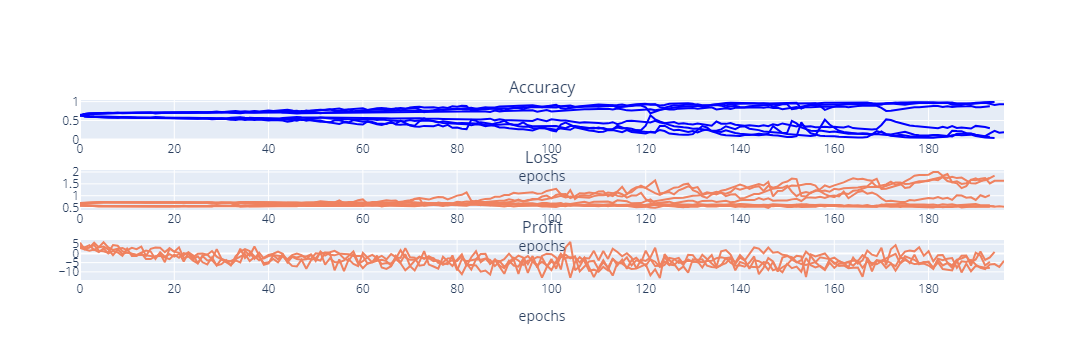

0.2 Model test start...
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.62574, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: 2.04
133/133 - 6s - 46ms/step - accuracy: 0.6135 - loss: 0.6593 - val_accuracy: 0.6720 - val_loss: 0.6257
Epoch 2/200

Epoch 2: val_loss improved from 0.62574 to 0.60861, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 0.31
133/133 - 3s - 24ms/step - accuracy: 0.6461 - loss: 0.6329 - val_accuracy: 0.6813 - val_loss: 0.6086
Epoch 3/200

Epoch 3: val_loss improved from 0.60861 to 0.60304, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 0.21
133/133 - 3s - 24ms/step - accuracy: 0.6531 - loss: 0.6262 - val_accuracy: 0.6920 - val_loss: 0.6030
Epoch 4/200

Epoch 4: val_loss improved from 0.60304 to 0.59860, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -1.47
133/133 - 3s - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.60972, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: -3.68
133/133 - 5s - 38ms/step - accuracy: 0.6205 - loss: 0.6591 - val_accuracy: 0.6720 - val_loss: 0.6097
Epoch 2/200

Epoch 2: val_loss improved from 0.60972 to 0.59503, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -1.31
133/133 - 3s - 23ms/step - accuracy: 0.6567 - loss: 0.6219 - val_accuracy: 0.6847 - val_loss: 0.5950
Epoch 3/200

Epoch 3: val_loss improved from 0.59503 to 0.58974, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 0.68
133/133 - 3s - 23ms/step - accuracy: 0.6698 - loss: 0.6114 - val_accuracy: 0.6980 - val_loss: 0.5897
Epoch 4/200

Epoch 4: val_loss improved from 0.58974 to 0.58295, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -0.58
133/133 - 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.61014, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: 1.65
133/133 - 5s - 39ms/step - accuracy: 0.6208 - loss: 0.6550 - val_accuracy: 0.6640 - val_loss: 0.6101
Epoch 2/200

Epoch 2: val_loss improved from 0.61014 to 0.59818, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 0.47
133/133 - 3s - 23ms/step - accuracy: 0.6565 - loss: 0.6210 - val_accuracy: 0.6720 - val_loss: 0.5982
Epoch 3/200

Epoch 3: val_loss improved from 0.59818 to 0.59051, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -4.99
133/133 - 3s - 24ms/step - accuracy: 0.6708 - loss: 0.6093 - val_accuracy: 0.7000 - val_loss: 0.5905
Epoch 4/200

Epoch 4: val_loss improved from 0.59051 to 0.57853, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 2.37
133/133 - 3s - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.61304, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Profit: 1.25
133/133 - 5s - 39ms/step - accuracy: 0.6156 - loss: 0.6598 - val_accuracy: 0.6593 - val_loss: 0.6130
Epoch 2/200

Epoch 2: val_loss improved from 0.61304 to 0.59561, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -1.93
133/133 - 3s - 24ms/step - accuracy: 0.6521 - loss: 0.6232 - val_accuracy: 0.6893 - val_loss: 0.5956
Epoch 3/200

Epoch 3: val_loss improved from 0.59561 to 0.58551, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 0.91
133/133 - 3s - 24ms/step - accuracy: 0.6701 - loss: 0.6094 - val_accuracy: 0.6953 - val_loss: 0.5855
Epoch 4/200

Epoch 4: val_loss improved from 0.58551 to 0.57909, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 3.41
133/133 - 3s - 

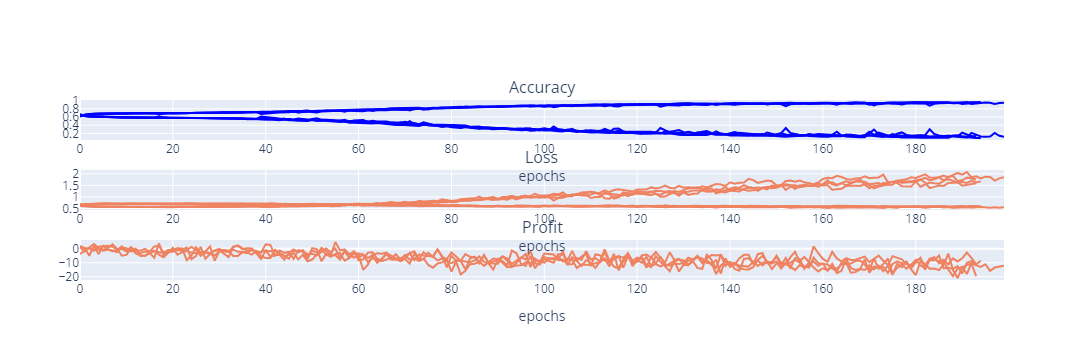

0.4 Model test start...
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.64291, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: -0.62
133/133 - 5s - 40ms/step - accuracy: 0.6061 - loss: 0.6624 - val_accuracy: 0.6507 - val_loss: 0.6429
Epoch 2/200

Epoch 2: val_loss improved from 0.64291 to 0.61725, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -2.88
133/133 - 3s - 23ms/step - accuracy: 0.6253 - loss: 0.6443 - val_accuracy: 0.6633 - val_loss: 0.6173
Epoch 3/200

Epoch 3: val_loss improved from 0.61725 to 0.60712, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -5.67
133/133 - 3s - 24ms/step - accuracy: 0.6424 - loss: 0.6372 - val_accuracy: 0.6727 - val_loss: 0.6071
Epoch 4/200

Epoch 4: val_loss did not improve from 0.60712
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -4.19
133/133 - 3s - 23ms/step - accuracy: 0.6448 - loss: 0.6314 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.62293, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Profit: -3.08
133/133 - 5s - 39ms/step - accuracy: 0.6014 - loss: 0.6658 - val_accuracy: 0.6500 - val_loss: 0.6229
Epoch 2/200

Epoch 2: val_loss improved from 0.62293 to 0.60697, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -2.1
133/133 - 3s - 24ms/step - accuracy: 0.6442 - loss: 0.6284 - val_accuracy: 0.6527 - val_loss: 0.6070
Epoch 3/200

Epoch 3: val_loss improved from 0.60697 to 0.60014, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -1.45
133/133 - 3s - 24ms/step - accuracy: 0.6566 - loss: 0.6197 - val_accuracy: 0.6733 - val_loss: 0.6001
Epoch 4/200

Epoch 4: val_loss improved from 0.60014 to 0.59324, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -1.91
133/133 - 3s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.62103, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: -4.53
133/133 - 6s - 43ms/step - accuracy: 0.6139 - loss: 0.6593 - val_accuracy: 0.6453 - val_loss: 0.6210
Epoch 2/200

Epoch 2: val_loss improved from 0.62103 to 0.60437, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -6.69
133/133 - 3s - 24ms/step - accuracy: 0.6393 - loss: 0.6288 - val_accuracy: 0.6727 - val_loss: 0.6044
Epoch 3/200

Epoch 3: val_loss did not improve from 0.60437
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -4.79
133/133 - 3s - 24ms/step - accuracy: 0.6546 - loss: 0.6220 - val_accuracy: 0.6727 - val_loss: 0.6101
Epoch 4/200

Epoch 4: val_loss improved from 0.60437 to 0.59092, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -1.37
133/133 - 3s - 24ms/step - accuracy: 0.6678 - loss: 0.6114 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.62711, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Profit: -3.75
133/133 - 5s - 37ms/step - accuracy: 0.6111 - loss: 0.6582 - val_accuracy: 0.6400 - val_loss: 0.6271
Epoch 2/200

Epoch 2: val_loss improved from 0.62711 to 0.60979, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -7.98
133/133 - 3s - 24ms/step - accuracy: 0.6471 - loss: 0.6279 - val_accuracy: 0.6467 - val_loss: 0.6098
Epoch 3/200

Epoch 3: val_loss improved from 0.60979 to 0.59471, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -2.69
133/133 - 3s - 24ms/step - accuracy: 0.6552 - loss: 0.6211 - val_accuracy: 0.6813 - val_loss: 0.5947
Epoch 4/200

Epoch 4: val_loss improved from 0.59471 to 0.59407, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -0.86
133/133 - 3s

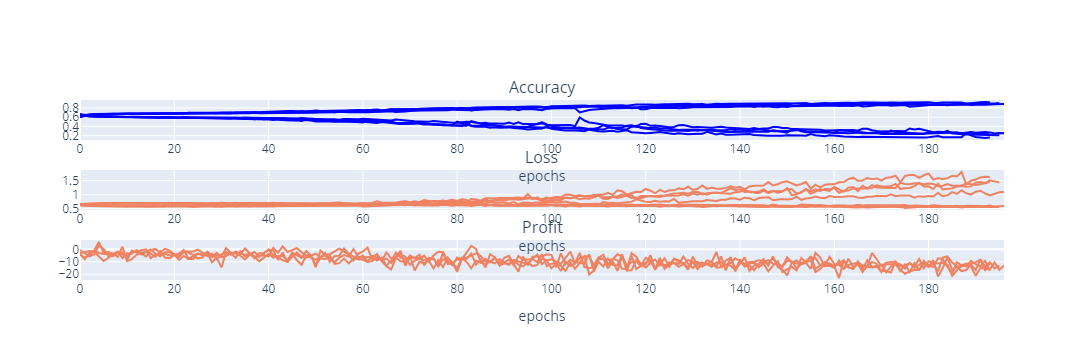

0.6 Model test start...
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.63762, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Profit: -8.33
133/133 - 5s - 39ms/step - accuracy: 0.5915 - loss: 0.6690 - val_accuracy: 0.6240 - val_loss: 0.6376
Epoch 2/200

Epoch 2: val_loss did not improve from 0.63762
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -7.27
133/133 - 3s - 24ms/step - accuracy: 0.6059 - loss: 0.6550 - val_accuracy: 0.6160 - val_loss: 0.6400
Epoch 3/200

Epoch 3: val_loss improved from 0.63762 to 0.62761, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -4.27
133/133 - 3s - 24ms/step - accuracy: 0.6146 - loss: 0.6493 - val_accuracy: 0.6620 - val_loss: 0.6276
Epoch 4/200

Epoch 4: val_loss improved from 0.62761 to 0.61864, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -5.08
133/133 - 3s - 24ms/step - accuracy: 0.6220 - loss: 0.6432 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.64904, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: -10.29
133/133 - 5s - 39ms/step - accuracy: 0.6036 - loss: 0.6678 - val_accuracy: 0.5880 - val_loss: 0.6490
Epoch 2/200

Epoch 2: val_loss improved from 0.64904 to 0.63364, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -9.48
133/133 - 3s - 24ms/step - accuracy: 0.6221 - loss: 0.6448 - val_accuracy: 0.6193 - val_loss: 0.6336
Epoch 3/200

Epoch 3: val_loss did not improve from 0.63364
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -8.44
133/133 - 3s - 23ms/step - accuracy: 0.6340 - loss: 0.6407 - val_accuracy: 0.6267 - val_loss: 0.6348
Epoch 4/200

Epoch 4: val_loss improved from 0.63364 to 0.63107, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -8.33
133/133 - 3s - 24ms/step - accuracy: 0.6359 - loss: 0.6340 - val_accur

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.65103, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: -9.87
133/133 - 5s - 39ms/step - accuracy: 0.6007 - loss: 0.6679 - val_accuracy: 0.5893 - val_loss: 0.6510
Epoch 2/200

Epoch 2: val_loss improved from 0.65103 to 0.62723, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -0.79
133/133 - 3s - 23ms/step - accuracy: 0.6275 - loss: 0.6413 - val_accuracy: 0.6187 - val_loss: 0.6272
Epoch 3/200

Epoch 3: val_loss improved from 0.62723 to 0.62239, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -5.36
133/133 - 3s - 23ms/step - accuracy: 0.6331 - loss: 0.6350 - val_accuracy: 0.6340 - val_loss: 0.6224
Epoch 4/200

Epoch 4: val_loss did not improve from 0.62239
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -9.12
133/133 - 3s - 23ms/step - accuracy: 0.6424 - loss: 0.6342 - val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.64425, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Profit: -4.03
133/133 - 5s - 39ms/step - accuracy: 0.6059 - loss: 0.6681 - val_accuracy: 0.5980 - val_loss: 0.6442
Epoch 2/200

Epoch 2: val_loss improved from 0.64425 to 0.63167, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -7.27
133/133 - 3s - 24ms/step - accuracy: 0.6248 - loss: 0.6436 - val_accuracy: 0.6160 - val_loss: 0.6317
Epoch 3/200

Epoch 3: val_loss improved from 0.63167 to 0.62900, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -5.37
133/133 - 3s - 24ms/step - accuracy: 0.6407 - loss: 0.6354 - val_accuracy: 0.6280 - val_loss: 0.6290
Epoch 4/200

Epoch 4: val_loss improved from 0.62900 to 0.62433, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -7.24
133/133 - 3s

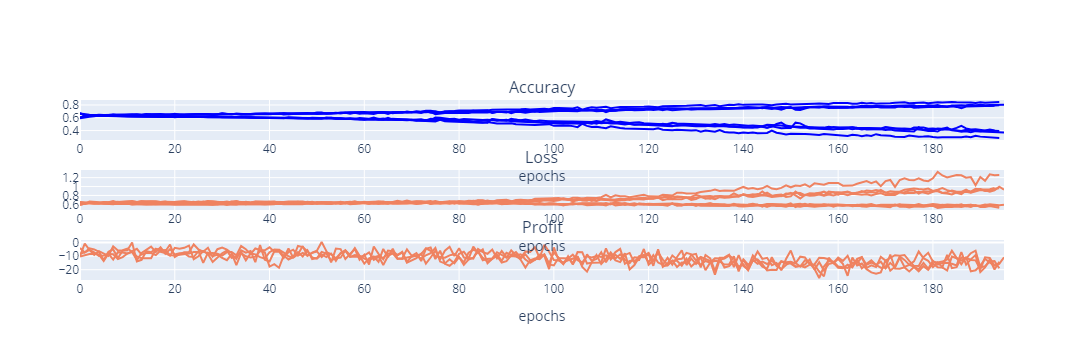

0.8 Model test start...
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.66513, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Profit: -12.23
133/133 - 5s - 38ms/step - accuracy: 0.5752 - loss: 0.6764 - val_accuracy: 0.5360 - val_loss: 0.6651
Epoch 2/200

Epoch 2: val_loss improved from 0.66513 to 0.65708, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -10.57
133/133 - 3s - 24ms/step - accuracy: 0.5674 - loss: 0.6661 - val_accuracy: 0.5633 - val_loss: 0.6571
Epoch 3/200

Epoch 3: val_loss did not improve from 0.65708
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -11.13
133/133 - 3s - 23ms/step - accuracy: 0.5692 - loss: 0.6664 - val_accuracy: 0.5500 - val_loss: 0.6593
Epoch 4/200

Epoch 4: val_loss improved from 0.65708 to 0.65284, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -15.99
133/133 - 3s - 24ms/step - accuracy: 0.5792 - loss: 0.6589 - val_ac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.67369, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Profit: -11.16
133/133 - 5s - 39ms/step - accuracy: 0.5864 - loss: 0.6793 - val_accuracy: 0.5260 - val_loss: 0.6737
Epoch 2/200

Epoch 2: val_loss improved from 0.67369 to 0.66233, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -11.52
133/133 - 3s - 23ms/step - accuracy: 0.5921 - loss: 0.6635 - val_accuracy: 0.5500 - val_loss: 0.6623
Epoch 3/200

Epoch 3: val_loss did not improve from 0.66233
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -9.31
133/133 - 3s - 24ms/step - accuracy: 0.5868 - loss: 0.6642 - val_accuracy: 0.5227 - val_loss: 0.6715
Epoch 4/200

Epoch 4: val_loss improved from 0.66233 to 0.65943, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -11.84
133/133 - 3s - 24ms/step - accuracy: 0.5982 - loss: 0.6584 - val_acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.66974, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: -5.62
133/133 - 5s - 40ms/step - accuracy: 0.5953 - loss: 0.6733 - val_accuracy: 0.5273 - val_loss: 0.6697
Epoch 2/200

Epoch 2: val_loss improved from 0.66974 to 0.66753, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -11.52
133/133 - 3s - 24ms/step - accuracy: 0.5940 - loss: 0.6637 - val_accuracy: 0.5413 - val_loss: 0.6675
Epoch 3/200

Epoch 3: val_loss improved from 0.66753 to 0.66639, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -11.44
133/133 - 3s - 24ms/step - accuracy: 0.6011 - loss: 0.6608 - val_accuracy: 0.5507 - val_loss: 0.6664
Epoch 4/200

Epoch 4: val_loss improved from 0.66639 to 0.65435, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -13.03
133/133 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.68216, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: -12.16
133/133 - 5s - 38ms/step - accuracy: 0.5981 - loss: 0.6777 - val_accuracy: 0.5180 - val_loss: 0.6822
Epoch 2/200

Epoch 2: val_loss improved from 0.68216 to 0.67312, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -14.69
133/133 - 3s - 23ms/step - accuracy: 0.5872 - loss: 0.6658 - val_accuracy: 0.5587 - val_loss: 0.6731
Epoch 3/200

Epoch 3: val_loss improved from 0.67312 to 0.67311, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: -10.98
133/133 - 3s - 24ms/step - accuracy: 0.5914 - loss: 0.6632 - val_accuracy: 0.5500 - val_loss: 0.6731
Epoch 4/200

Epoch 4: val_loss improved from 0.67311 to 0.66571, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: -8.78
133/133 -

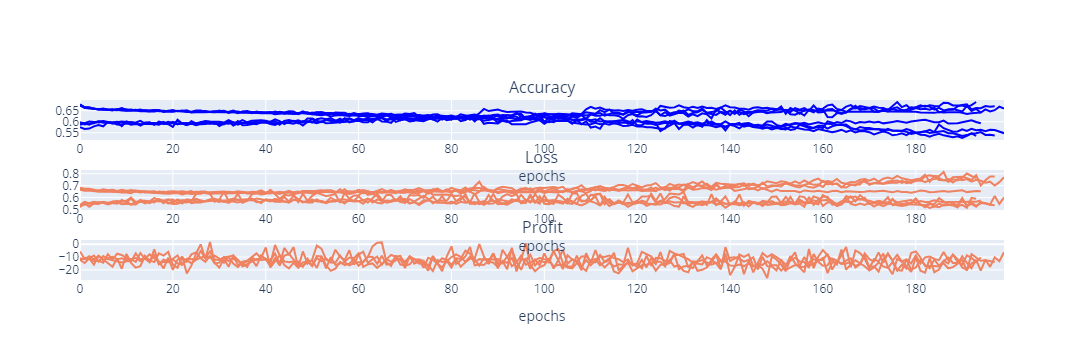

               0        0.2        0.4        0.6        0.8
count   4.000000   4.000000   4.000000   4.000000   4.000000
mean   72.866666  71.450000  69.383335  65.116668  57.799999
std     0.524933   0.520328   0.710503   1.020350   2.875696
min    72.200000  70.733333  68.466669  63.666666  55.133331
25%    72.649999  71.233332  69.166668  64.816667  56.383334
50%    72.900000  71.599999  69.433334  65.400001  57.100001
75%    73.116668  71.816666  69.650002  65.700002  58.516666
max    73.466665  71.866667  70.200002  66.000003  61.866665
              0       0.2       0.4       0.6       0.8
count  4.000000  4.000000  4.000000  4.000000   4.00000
mean   0.950000 -2.600000 -2.377500 -8.347500  -9.75000
std    2.155737  1.995562  1.341973  0.581457   2.09838
min   -2.110000 -4.150000 -3.790000 -8.850000 -12.47000
25%    0.215000 -3.550000 -3.130000 -8.677500 -10.79000
50%    1.680000 -3.290000 -2.550000 -8.510000  -9.43000
75%    2.415000 -2.340000 -1.797500 -8.180000  -8.39000
max

In [18]:
# Run
from numpy import dtype

repeats = 4
runMeter = 0
results_acc = DataFrame(dtype='float')
results_profit = DataFrame(dtype='float')
results_profitOld = DataFrame(dtype='float')
metrics = list()

# vary training epochs
learning_rate = 0.001
features = 0
model = 0 # [0, 1, 2]
dropout = [0, 0.2, 0.4, 0.6, 0.8]
denseType = 0
neuronsLstm = 150
timeStep = 150
epochs = 200

# Data gen
x_train, x_test, y_train, y_test, Y_test = data(timeStep, features)

# for dr in dropout:
for dr in dropout:
 print(f"{dr} Model test start...")
 
 results_acc[str(dr)], results_profit[str(dr)], results_profitOld[str(dr)], metrics = experiment(
                                                                                            runMeter, 
                                                                                            repeats, 
                                                                                            epochs, 
                                                                                            neuronsLstm, 
                                                                                            timeStep, 
                                                                                            denseType, 
                                                                                            dr, 
                                                                                            model, 
                                                                                            features, 
                                                                                            learning_rate
                                                                                            )
                          
#  runMeter += 1
 plotsOut(dr, metrics)

# summarize results
print(results_acc.describe())
print(results_profit.describe())
print(results_profitOld.describe())

In [19]:
# summarize results
print(results_acc.describe())
print(results_profit.describe())

               0        0.2        0.4        0.6        0.8
count   4.000000   4.000000   4.000000   4.000000   4.000000
mean   72.866666  71.450000  69.383335  65.116668  57.799999
std     0.524933   0.520328   0.710503   1.020350   2.875696
min    72.200000  70.733333  68.466669  63.666666  55.133331
25%    72.649999  71.233332  69.166668  64.816667  56.383334
50%    72.900000  71.599999  69.433334  65.400001  57.100001
75%    73.116668  71.816666  69.650002  65.700002  58.516666
max    73.466665  71.866667  70.200002  66.000003  61.866665
              0       0.2       0.4       0.6       0.8
count  4.000000  4.000000  4.000000  4.000000   4.00000
mean   0.950000 -2.600000 -2.377500 -8.347500  -9.75000
std    2.155737  1.995562  1.341973  0.581457   2.09838
min   -2.110000 -4.150000 -3.790000 -8.850000 -12.47000
25%    0.215000 -3.550000 -3.130000 -8.677500 -10.79000
50%    1.680000 -3.290000 -2.550000 -8.510000  -9.43000
75%    2.415000 -2.340000 -1.797500 -8.180000  -8.39000
max

               0        0.2        0.4        0.6        0.8
count   4.000000   4.000000   4.000000   4.000000   4.000000
mean   72.866666  71.450000  69.383335  65.116668  57.799999
std     0.524933   0.520328   0.710503   1.020350   2.875696
min    72.200000  70.733333  68.466669  63.666666  55.133331
25%    72.649999  71.233332  69.166668  64.816667  56.383334
50%    72.900000  71.599999  69.433334  65.400001  57.100001
75%    73.116668  71.816666  69.650002  65.700002  58.516666
max    73.466665  71.866667  70.200002  66.000003  61.866665


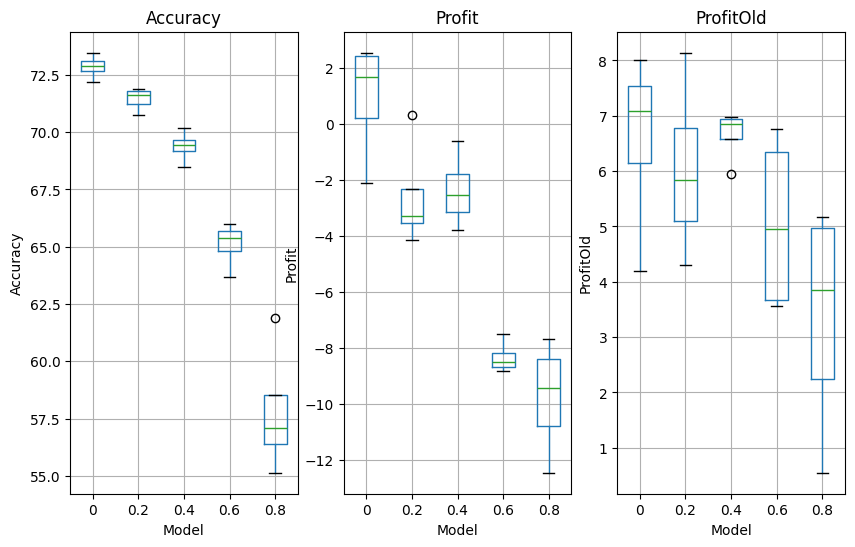

In [20]:
%matplotlib inline
print(results_acc.describe())

# 2 subplots in one row
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

# Generate boxplots
results_acc.boxplot(ax=ax[0])
results_profit.boxplot(ax=ax[1])
results_profitOld.boxplot(ax=ax[2])

# Set labels and titles
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Profit')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Profit')
ax[2].set_title('ProfitOld')
ax[2].set_xlabel('Model')
ax[2].set_ylabel('ProfitOld')

# Save to .png and show plot
plt.savefig(f'boxplot_dropout.png')
plt.show()